#  XGB Model

In [1]:
import datetime
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

'''for saving models'''
from joblib import dump, load

In [2]:
# MANIFEST - list of versions on board 
import sys
import os
print(pd.datetime.now())
print('OS: '+os.uname().sysname)
print('Python: '+sys.version)
print('numpy: '+np.__version__)
print('pandas: '+pd.__version__)
print('sklearn: '+sklearn.__version__)

2020-01-28 13:22:29.950696
OS: Linux
Python: 3.6.7 | packaged by conda-forge | (default, Nov  6 2019, 16:19:42) 
[GCC 7.3.0]
numpy: 1.17.3
pandas: 0.25.3
sklearn: 0.22.1


## Data Prep

In [3]:
FOLDER = '../mortality_prediction_docker_model/v2/scratch/'
train_file = FOLDER+'train_all_nw.csv'
train = pd.read_csv(train_file,low_memory = False)
train.shape

(97918, 235)

In [4]:
train.head()

,ethnicity_concept_id,visit_duration,person_id,days_since_latest_visit,death_in_next_window,number_of_visits,race_concept_name,gender_concept_id,old,visit_concept_name,...,condition_concept_77639,condition_concept_135215,procedure_concept_2001414,condition_concept_198194,procedure_concept_2005379,condition_concept_77139,procedure_concept_2003939,procedure_concept_2109792,procedure_concept_2003789,procedure_concept_2110916
0,NaN,0,0,1000,0,15,Unknown,8507,87.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0,5,1000,0,15,Native Hawaiian or Other Pacific Islander,8507,75.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1,6,1000,0,10,White,8532,34.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,38003564.0,0,7,1000,0,5,American Indian or Alaska Native,8532,72.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,38003564.0,0,8,1000,0,1,American Indian or Alaska Native,8532,76.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
start_mem = train.memory_usage().sum() / 1024**2
print('Memory usage is {:.2f} MB'.format(start_mem))

Memory usage is 175.56 MB


In [6]:
def cols_toint(df):
    df = df.fillna(0)
    df.old = df.old.astype(int)
    for c in df.columns[df.columns.str.startswith('days')]:
        df[c] = df[c].astype(int)
    return df

In [7]:
train = cols_toint(train)

In [8]:
def reduce_mem_usage(df):
    '''https://www.mikulskibartosz.name/how-to-reduce-memory-usage-in-pandas/'''
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and col_type :
                c_min = df[col].min()
                c_max = df[col].max()
                c_unique = len(df[col].unique())

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                        df[col] = df[col].astype(np.uint8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                        df[col] = df[col].astype(np.uint16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                        df[col] = df[col].astype(np.uint32)                    
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                    elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)

                if c_min == 0.0 and c_max == 1.0 and c_unique == 2:
                    df[col] = df[col].astype(bool)
                    pass
                
#                 if 2 > c_unique and c_unique < 21: # convert to categorical - needs more work
#                     df[col] = pd.Categorical(df[col])


    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 175.56 MB
Memory usage after optimization is: 24.75 MB
Decreased by 85.9%


In [61]:
train.head()

,ethnicity_concept_id,visit_duration,person_id,death_in_next_window,number_of_visits,race_concept_name,gender_concept_id,old,visit_concept_name,race_concept_id,...,condition_concept_77639,condition_concept_135215,procedure_concept_2001414,condition_concept_198194,procedure_concept_2005379,condition_concept_77139,procedure_concept_2003939,procedure_concept_2109792,procedure_concept_2003789,procedure_concept_2110916
0,0.0,0,0,False,15,4,8507,87,3,8552.0,...,False,False,False,False,False,False,False,False,False,False
1,0.0,0,5,False,15,3,8507,75,6,8560.0,...,False,False,False,False,False,False,False,False,False,False
2,0.0,1,6,False,10,5,8532,34,2,8528.0,...,False,False,False,False,False,False,False,False,False,False
3,38003564.0,0,7,False,5,0,8532,72,2,8656.0,...,False,False,False,False,False,False,False,False,False,False
4,38003564.0,0,8,False,1,0,8532,76,0,8656.0,...,False,False,False,False,False,False,False,False,False,False


In [98]:
def find_dup_cols(df):
    '''
    Find duplicate columns:
    >>> df = pd.DataFrame([[1,1,1], [2,2,2], [3,3,3]], columns=['a','b','c']); find_dup_cols(df)
    ['b', 'c']
    '''
    i = 1
    dupes = []
    for c in df.columns:
        for d in df.columns[i:]:
            if len(pd.Series(list(zip(df[c], df[d]))).unique()) == len(df[c].unique()) == len(df[d].unique()):
                dupes += d
            i += 1
    return dupes

from doctest import testmod
testmod(name='find_dup_cols')

TestResults(failed=0, attempted=1)

In [11]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train.race_concept_name = train.race_concept_name.replace(to_replace=0, value='Unknown')
train.race_concept_name = train.race_concept_name.fillna('Unknown')
label_encoder = label_encoder.fit(train.race_concept_name)
train.race_concept_name = label_encoder.transform(train.race_concept_name)

In [12]:
train.describe(include='all').T.fillna('')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ethnicity_concept_id,97918.0,,,,2.12698e+07,1.88642e+07,0,0,3.80036e+07,3.80036e+07,3.80036e+07
visit_duration,97918.0,,,,1.98161,8.13483,0,0,0,0,286
person_id,97918.0,,,,75766.8,43725.7,0,37954.2,75580,113732,151684
days_since_latest_visit,97918.0,,,,990.939,85.7945,0,1000,1000,1000,1000
death_in_next_window,97918.0,2,False,97403,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...
condition_concept_77139,97918.0,2,False,97593,,,,,,,
procedure_concept_2003939,97918.0,2,False,97741,,,,,,,
procedure_concept_2109792,97918.0,2,False,97687,,,,,,,
procedure_concept_2003789,97918.0,2,False,97854,,,,,,,


In [13]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
ethnicity_concept_id,97918.0,2.126985e+07,1.886417e+07,0.0,0.00,38003564.0,38003564.00,38003564.0
visit_duration,97918.0,1.981607e+00,8.134833e+00,0.0,0.00,0.0,0.00,286.0
person_id,97918.0,7.576679e+04,4.372571e+04,0.0,37954.25,75580.0,113731.75,151684.0
days_since_latest_visit,97918.0,9.909387e+02,8.579449e+01,0.0,1000.00,1000.0,1000.00,1000.0
number_of_visits,97918.0,1.132194e+01,3.776720e+01,0.0,1.00,3.0,10.00,2000.0
race_concept_name,97918.0,2.708501e+00,1.667356e+00,0.0,1.00,3.0,4.00,5.0
gender_concept_id,97918.0,8.521069e+03,1.240115e+01,8507.0,8507.00,8532.0,8532.00,8532.0
old,97918.0,7.310756e+01,1.261579e+01,0.0,68.00,74.0,81.00,101.0
visit_concept_name,97918.0,1.735125e+00,5.940125e+00,0.0,0.00,0.0,2.00,273.0
race_concept_id,97918.0,NaN,NaN,0.0,8512.00,8528.0,8560.00,8656.0


In [14]:
train.shape

(97918, 235)

In [39]:
train = train.drop(train.columns[train.columns.str.startswith('days_since')], axis=1)

In [40]:
X = train.drop(['death_in_next_window','person_id'], axis = 1)
train_features = X.columns.values
y = train[['death_in_next_window']]
X = np.array(X)
y = np.array(y).ravel()

In [41]:
test_file = FOLDER+'test_all_nw.csv'
test = pd.read_csv(test_file,low_memory = False)
test.shape

(28488, 235)

In [42]:
test = cols_toint(test)
test.shape

(28488, 235)

In [43]:
test.race_concept_name = test.race_concept_name.replace(to_replace=0, value='Unknown')
test.race_concept_name = test.race_concept_name.fillna('Unknown')
test.race_concept_name = label_encoder.transform(test.race_concept_name)

In [44]:
test = test.drop(test.columns[test.columns.str.startswith('days_since')], axis=1)

In [45]:
X_test = test.drop(['death_in_next_window','person_id'], axis = 1)
X_test = X_test[train_features]  # order the test columns like train
test_features = X_test.columns.values
y_test = test[['death_in_next_window']]
X_test = np.array(X_test)
y_test = np.array(y_test).ravel()

## XGB Model

In [46]:
import xgboost as xgb
xgb.__version__

'0.90'

In [52]:
params = {
    'eval_metric': ['auc', 'error'],
    'tree_method' : 'auto',
    'random_state' : 1234,
    'reg_lambda' : 1.0,
    'min_child_weight' : 1.0,
    'max_bin' : 256,
    'min_split_loss' : 0.01,
    'max_depth' : 10,
    'reg_alpha' : 0.0,
    'colsample_bylevel' : 1.0,
    'scale_pos_weight' : 1.0,
    'max_delta_step' : 0.0,
    'learning_rate' : 0.05,
    'n_estimators' : 1000,
    'num_parallel_tree' : 1,
    'colsample_bytree' : 0.5,
    'subsample' : 1.0,
    'n_jobs': -1.0,
}

num_round = 1000

In [53]:
evals_result ={}

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert our data into XGBoost format
d_train = xgb.DMatrix(X_train, y_train, feature_names=train_features)
d_valid = xgb.DMatrix(X_valid, y_valid,  feature_names=train_features)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

xgb_model = xgb.train(params=params, dtrain=d_train, num_boost_round=num_round, 
                      evals=watchlist, evals_result=evals_result, 
                      early_stopping_rounds=50, verbose_eval=False)
xgb_model.best_iteration

0

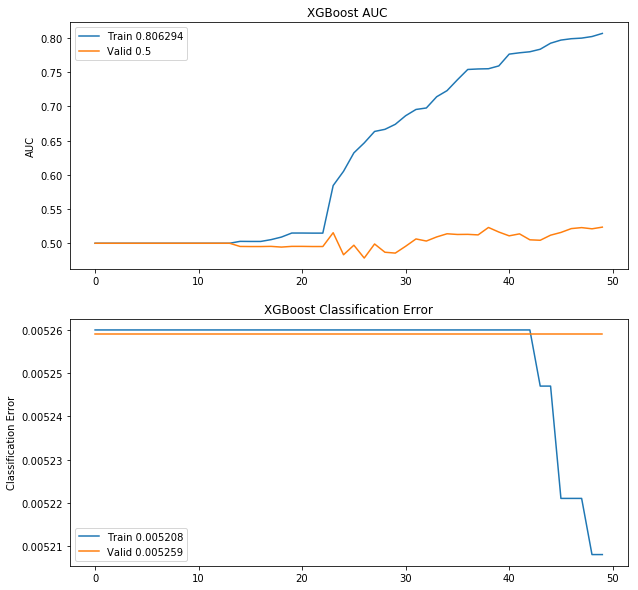

In [60]:
# plot learning curve
epochs = len(evals_result['train']['auc'])
x_axis = range(0, epochs)
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
ax1.plot(x_axis, evals_result['train']['auc'], label='Train '+str(evals_result['train']['auc'][-1]))
ax1.plot(x_axis, evals_result['valid']['auc'], label='Valid '+str(evals_result['valid']['auc'][xgb_model.best_iteration]))
ax1.ticklabel_format(useOffset=False, style='plain')
ax1.legend()
ax1.set_ylabel('AUC')
ax1.set_title('XGBoost AUC ')
ax2.plot(x_axis, evals_result['train']['error'], label='Train '+str(evals_result['train']['error'][-1]))
ax2.plot(x_axis, evals_result['valid']['error'], label='Valid '+str(evals_result['valid']['error'][xgb_model.best_iteration]))
ax2.ticklabel_format(useOffset=False, style='plain')
ax2.legend()
ax2.set_ylabel('Classification Error')
ax2.set_title('XGBoost Classification Error')
plt.show()

In [25]:
# Predict on test data
d_test = xgb.DMatrix(X_test, y_test, feature_names=test_features)

preds = xgb_model.predict(d_test, ntree_limit=xgb_model.best_ntree_limit)

In [26]:
y_scores = preds

## Eval

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

In [28]:
print('AUC =',roc_auc_score(y_test, y_scores))

AUC = 0.9987777156900508


In [29]:
# fig, ax = plt.subplots()
# plot_roc_curve(xgb_model, X_test, y_test, ax=ax)
# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#         label='Chance', alpha=.8)

# ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
#        title="AUC")
# ax.legend(loc="lower right")
# plt.show()

In [30]:
from sklearn import metrics
def buildROC(target_test,test_preds):
    '''Compute micro-average ROC curve and ROC area'''
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.rcParams["figure.figsize"] = (8,8)

    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('AUC')
    plt.show()

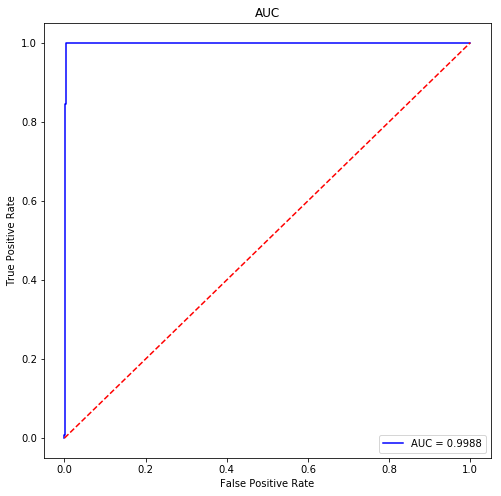

In [31]:
buildROC(y_test,preds)

In [32]:
# !pip install scikit-plot

In [33]:
# import scikitplot as skplt
# plt.rcParams["figure.figsize"] = (10,10)
# skplt.metrics.plot_roc(y_test, preds)

In [34]:
average_precision = average_precision_score(y_test, y_scores)
print('PRAUC = ', average_precision)

PRAUC =  0.737624034058128


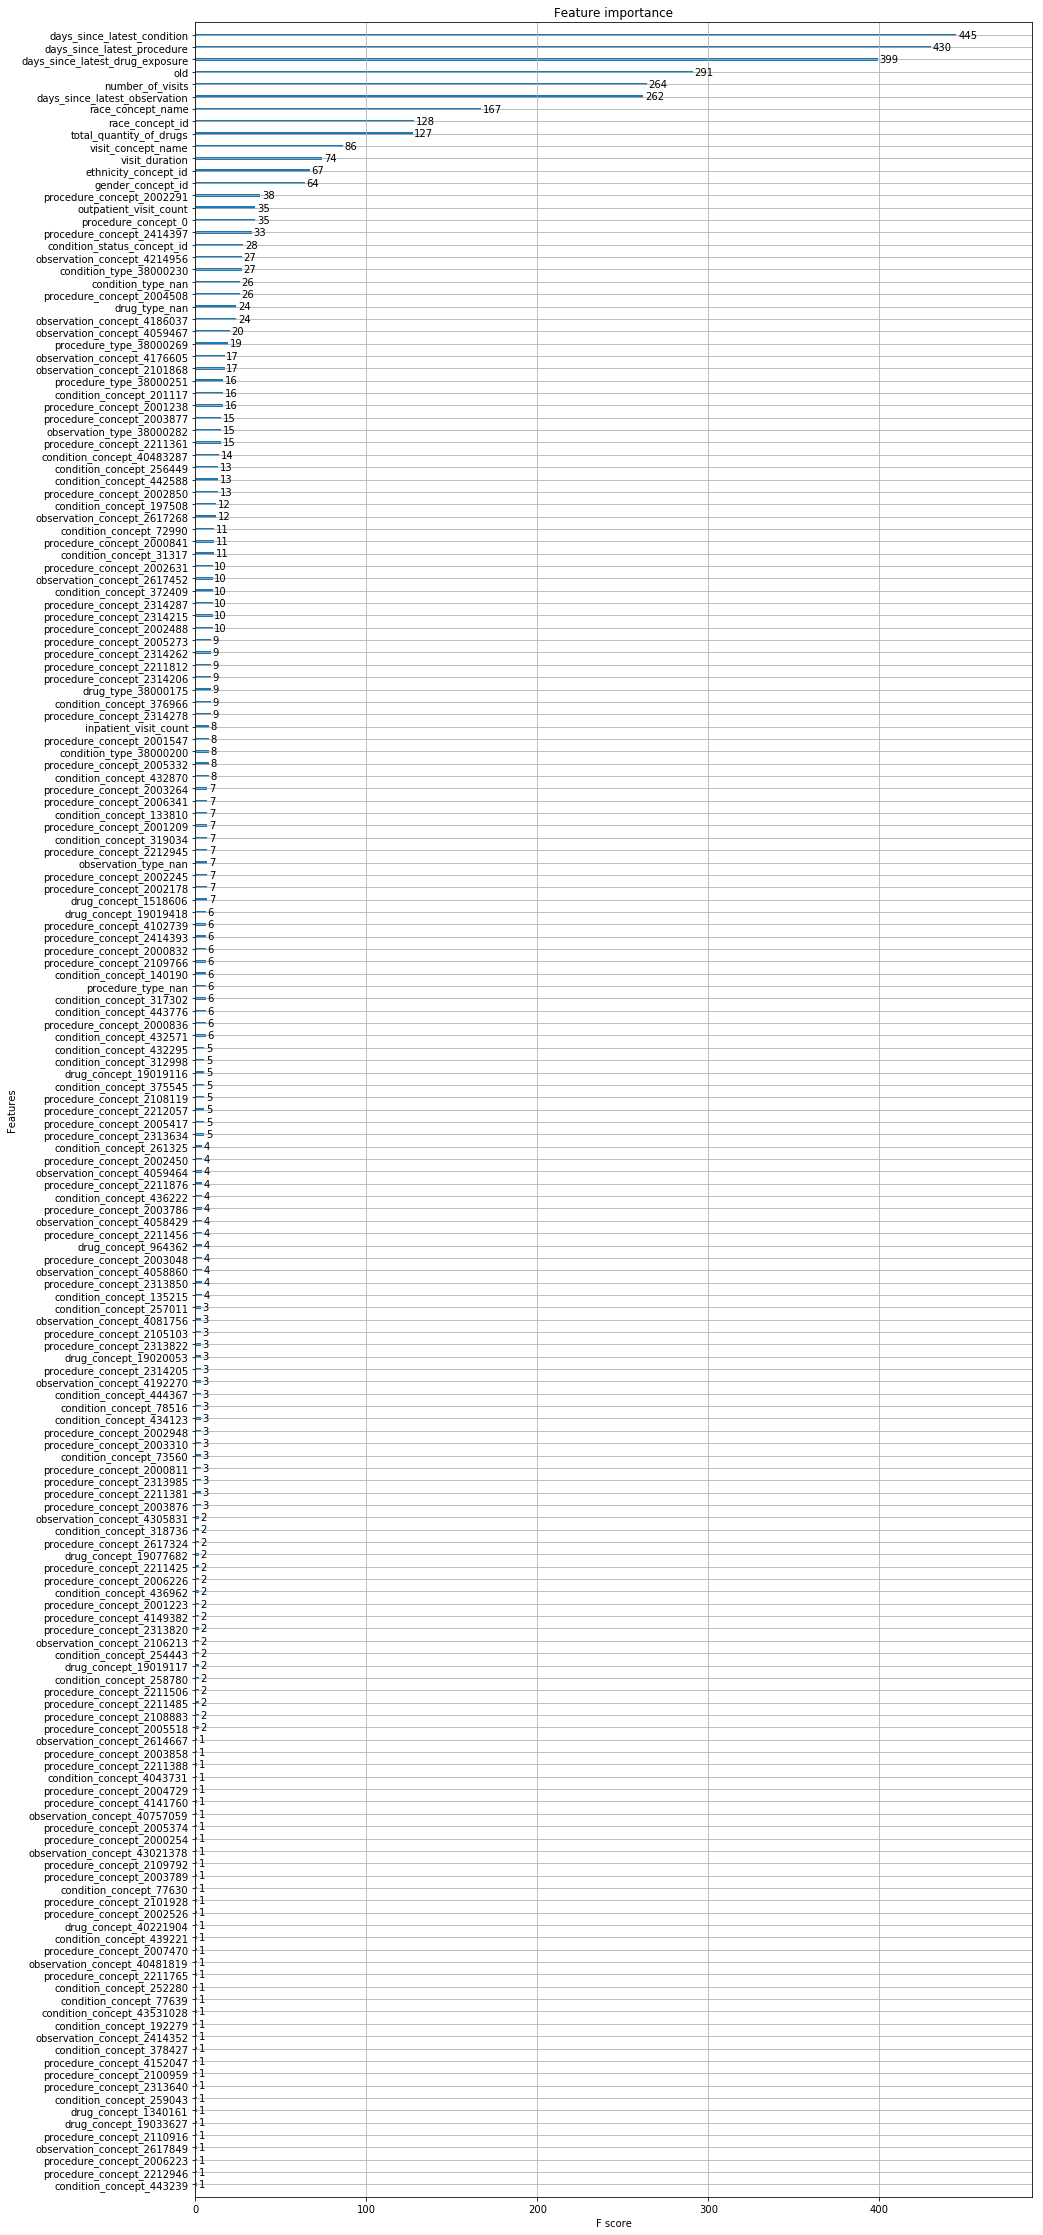

In [35]:
plt.rcParams["figure.figsize"] = (15,40)
ax = xgb.plot_importance(xgb_model)

## Full train

In [48]:
params = {
    'eval_metric': 'auc',
    'tree_method' : 'auto',
    'random_state' : 1234,
    'reg_lambda' : 1.0,
    'min_child_weight' : 1.0,
    'max_bin' : 256,
    'min_split_loss' : 0.01,
    'max_depth' : 10,
    'reg_alpha' : 0.0,
    'colsample_bylevel' : 1.0,
    'scale_pos_weight' : 1.0,
    'max_delta_step' : 0.0,
    'learning_rate' : 0.05,
    'n_estimators' : 1000,
    'num_parallel_tree' : 1,
    'colsample_bytree' : 0.5,
    'subsample' : 1.0,
    'n_jobs': -1.0,
}

num_round = 1000

In [55]:
df_preds = pd.DataFrame()
evals_result ={}

d_train_full = xgb.DMatrix(X, y, feature_names=train_features)
watchlist = [(d_train_full, 'train_full')]

xgb_model = xgb.train(params, d_train_full, num_round, watchlist,
                      early_stopping_rounds=50, maximize=True, 
                      verbose_eval=False)

In [58]:
model_file = 'xgb_model.joblib'
dump(xgb_model, model_file)

['xgb_model.joblib']

In [59]:
xgb_model_2 = load(model_file)
type(xgb_model_2)